<a href="https://colab.research.google.com/github/DineshReddy0530/Data-Science/blob/master/TwitterDisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,accuracy_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train[1100:1110]

,id,keyword,location,text,target
1100,1591,bombed,"DaKounty, Pa",@CyhiThePrynce bombed on Kanye in that #Elepha...,1
1101,1593,bombed,NaN,The majority of those killed were civilians on...,1
1102,1594,bombed,Tokyo,70 years ago at this hour the USA A-bombed Hir...,1
1103,1595,bombed,"DÌ_sseldorf, Germany",On 1st August #Turkish jets bombed the village...,1
1104,1596,bombed,Old Blighty,@NickLee8 i went to school in a bombed out Ea...,1
1105,1597,bombed,NaN,Photo bombed ???? http://t.co/arTUMHmBhh,0
1106,1599,bombed,NaN,@QPR1980 @Rorington95 Nowt to do with money. F...,0
1107,1600,bombed,??,'the third generation atomic bombed survivor' ...,1
1108,1601,bombed,NaN,@oooureli @Abu_Baraa1 You mean like the tolera...,0
1109,1602,bombed,NaN,@BrodyFrieling @hanna_brooksie photo bombed,0


In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


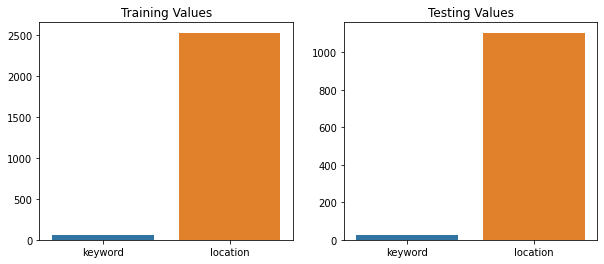

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.barplot(train[['keyword','location']].isnull().sum().index,train[['keyword','location']].isnull().sum().values)
plt.title('Training Values')

plt.subplot(122)
sns.barplot(test[['keyword','location']].isnull().sum().index,test[['keyword','location']].isnull().sum().values)
plt.title('Testing Values')
plt.show()


In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


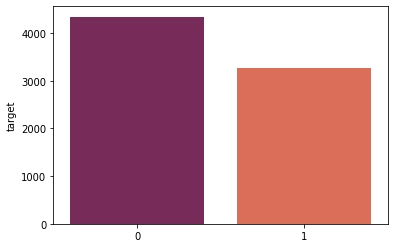

In [10]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette='rocket')

In [11]:
disaster_tweets=train[train['target']==1]['text']
print(disaster_tweets.values[0])
print('-'*50)
non_disaster_tweets = train[train['target']==0]['text']
print(non_disaster_tweets.values[0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
--------------------------------------------------
What's up man?


In [12]:
train['keyword'].nunique()

221

In [13]:
train['keyword'].value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
harm           41
body%20bags    41
damage         41
siren          40
evacuate       40
outbreak       40
windstorm      40
fear           40
collided       40
twister        40
flames         39
sinkhole       39
wrecked        39
derailment     39
wreckage       39
sunk           39
Name: keyword, dtype: int64

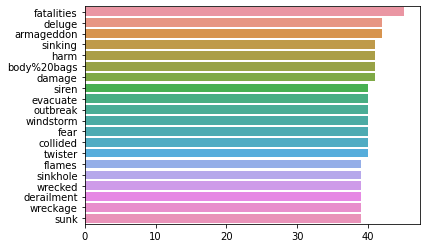

In [14]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts().values[:20],orient='h')

In [15]:
train[train['keyword']=='weapon']['target'].value_counts()

0    25
1    14
Name: target, dtype: int64

In [16]:
train.loc[0]

id                                                          1
keyword                                                   NaN
location                                                  NaN
text        Our Deeds are the Reason of this #earthquake M...
target                                                      1
Name: 0, dtype: object

In [17]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)]['target'].value_counts()

1    102
0     40
Name: target, dtype: int64

In [18]:
train['location'].value_counts()[:20]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
San Francisco       14
Name: location, dtype: int64

In [19]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

In [20]:
train['location'].value_counts()[:20]

USA                 445
UK                  118
Africa               51
India                46
Worldwide            45
Canada               41
Washington, DC       21
Australia            18
Indonesia            13
Sacramento, CA       10
ss                   10
Dallas, TX            9
World                 9
US                    9
304                   9
Manchester            9
Nashville, TN         9
San Diego, CA         9
Denver, Colorado      9
Scotland              8
Name: location, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


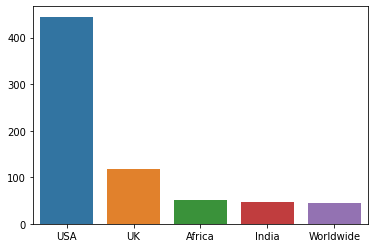

In [21]:
sns.barplot(train['location'].value_counts().index[:5],train['location'].value_counts().values[:5])

In [22]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text=emoji_pattern.sub(r'', text)
    return text

In [23]:
train['text']=train['text'].apply(lambda x:clean_text(x))

In [24]:
test['text']=test['text'].apply(lambda x:clean_text(x))

In [25]:
train[train["target"] == 1]["text"].values[-1]

'the latest more homes razed by northern california wildfire  abc news '

In [26]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')


In [27]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [28]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

In [29]:
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
def remove_stopwords(text):
  return [w for w in text if w not in stopwords.words('english')]

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [32]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [33]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatized_words(text):
  return [lemmatizer.lemmatize(word) for word in text]

In [34]:
train['text']=train['text'].apply(lambda x: lemmatized_words(x))
test['text']=test['text'].apply(lambda x: lemmatized_words(x))

In [35]:
test['text']

0                        [happened, terrible, car, crash]
1       [heard, earthquake, different, city, stay, saf...
2       [forest, fire, spot, pond, goose, fleeing, acr...
3               [apocalypse, lighting, spokane, wildfire]
4                [typhoon, soudelor, kill, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety,...
3259    [storm, ri, worse, last, hurricane, hardest, h...
3260                   [green, line, derailment, chicago]
3261       [meg, issue, hazardous, weather, outlook, hwo]
3262    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 3263, dtype: object

In [36]:
def combine_text(text):
  sentence=" ".join(text)
  return sentence

train['text']=train['text'].apply(lambda x:combine_text(x))
test['text']=test['text'].apply(lambda x:combine_text(x))

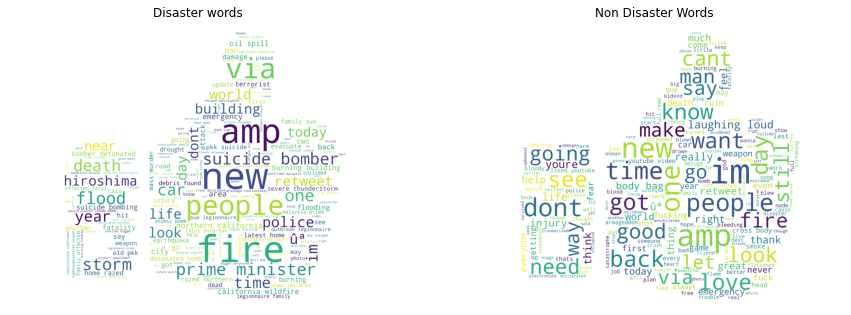

In [37]:
disaster_tweets=train[train['target']==1]['text']
non_disaster_tweets=train[train['target']==0]['text']

from wordcloud import WordCloud
from PIL import Image
our_mask=np.array(Image.open('upvote.png'))
plt.figure(figsize=(15,8))

plt.subplot(121)
wordcloud1 = WordCloud( background_color='white',
                        mask=our_mask,
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
plt.title('Disaster words')
plt.imshow(wordcloud1)
plt.axis('off')

plt.subplot(122)
wordcloud2 = WordCloud( background_color='white',
                        mask=our_mask,
                        width=600,
                        height=400,min_font_size=20).generate(" ".join(non_disaster_tweets))
plt.title("Non Disaster Words")
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

In [38]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


In [39]:
count_vectorizer=CountVectorizer()
train_vectors=count_vectorizer.fit_transform(train['text'])
print(train_vectors)


  (0, 3305)	1
  (0, 10714)	1
  (0, 4007)	1
  (0, 8181)	1
  (0, 357)	1
  (0, 5014)	1
  (1, 5004)	1
  (1, 4827)	1
  (1, 8921)	1
  (1, 7373)	1
  (1, 11213)	1
  (1, 11461)	1
  (1, 1943)	1
  (2, 10963)	1
  (2, 757)	1
  (2, 11813)	2
  (2, 9993)	2
  (2, 9157)	1
  (2, 9302)	1
  (2, 4403)	1
  (2, 9481)	1
  (2, 4493)	1
  (3, 4403)	1
  (3, 9481)	1
  (3, 9813)	1
  :	:
  (7609, 13252)	1
  (7609, 13684)	1
  (7610, 14255)	1
  (7610, 5869)	1
  (7611, 2000)	1
  (7611, 10085)	1
  (7611, 11081)	1
  (7611, 6586)	1
  (7611, 7709)	1
  (7611, 11705)	1
  (7611, 6703)	1
  (7611, 13308)	1
  (7611, 2558)	1
  (7611, 4030)	2
  (7611, 10135)	1
  (7611, 12741)	1
  (7611, 9101)	1
  (7612, 14569)	1
  (7612, 1906)	1
  (7612, 6121)	1
  (7612, 8986)	1
  (7612, 7453)	1
  (7612, 9129)	1
  (7612, 23)	1
  (7612, 10660)	1


In [40]:
test_vectors=count_vectorizer.transform(test['text'])

In [41]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

In [42]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [43]:
from sklearn.model_selection import cross_val_score
clf_lg=LogisticRegression(C= 1,penalty= 'l2',solver='liblinear')

#KFold CrossValidation
scores_bow=cross_val_score(clf_lg,train_vectors,train['target'],cv=kf,scoring='accuracy')
scores_tfidf=cross_val_score(clf_lg, train_tfidf, train["target"], cv=kf, scoring="accuracy")
print(scores_bow.mean())
print(scores_tfidf.mean())


0.8044121045316116
0.8029671553867855


In [44]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()

#KFold CrossValidation
scores_bow=cross_val_score(clf,train_vectors,train['target'],cv=kf,scoring='accuracy')
scores_tfidf=cross_val_score(clf, train_tfidf, train["target"], cv=kf, scoring="accuracy")
print(scores_bow.mean())
print(scores_tfidf.mean())

0.7911435429966787
0.7872053279805202


In [45]:
train_tfidf.shape

(7613, 15075)

In [46]:
#Grid Search CrossValidation:
parameters={'solver':['lbfgs', 'liblinear', 'sag', 'saga'],'penalty':['l1','l2','elasticnet','none'],'C':[0.1,1,10,20,100]}
grid_search=GridSearchCV(clf_lg,param_grid=parameters,scoring='accuracy',cv=5,n_jobs=-1)
grid_search.fit(train_tfidf, train["target"])
print('Best Score:{}'.format(grid_search.best_score_))
print('Best parameters:{}'.format(grid_search.best_params_))

Best Score:0.7070852275619648
Best parameters:{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [47]:
from sklearn.linear_model import RidgeClassifier
clf_rc=RidgeClassifier()
scores_bow=cross_val_score(clf_rc,train_vectors,train['target'],cv=kf,scoring='accuracy')
scores_tfidf = cross_val_score(clf_rc, train_tfidf, train["target"], cv=kf, scoring="f1")
print(scores_bow.mean())
print(scores_tfidf.mean())

0.7753839574258211
0.7485779928011828


In [48]:
clf_lg.fit(train_tfidf,train['target'])
y_pred=clf_lg.predict(test_tfidf)


In [49]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])